In [1]:
import numpy as np
from matplotlib import pyplot as plt
import myokit

plt.rcParams['font.size'] = 15
plt.rcParams['font.weight'] ='bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15

# Cardiac electrophysiology

![alt text](https://www.researchgate.net/profile/Norbert_Jost/publication/249962676/figure/fig1/AS:298374185144327@1448149357782/Electrical-activity-in-the-myocardium-Schematic-of-a-human-heart-with-illustration-of.png)



Cardiac action potential phases:
- 0: rapid inflow of Na ions (depolarization), the action potential rises fast with $I_{Na}$.
- 1: the flow of Na ions stops and the there is a brief outflow of K ions with $I_{to}$.
- 2: there is an inflow of Ca ions that keep the potential high with $I_{CaL}$
- 3: the cell repolarizes maily with K ions flowing out of the cell with $I_{Kr}, I_{Ks}, I_{K1}$. The inflow of Ca ions stops.
- 4: the ion balances are restored, for example, with the sodium/potassium ion pump.

### O'Hara Rudy model (2011)

<img src="CardiacEP/ohara.png" alt="drawing" width="350"/>

Remember that:
$$C_m\frac{dV}{dt} = - \sum_x I_x$$ 

In [2]:
m, p, x = myokit.load('CardiacEP/ohara-2011.mmt')

dict_blocks = {'Nap': 'ina.block',
                    'Kr': 'ikr.block',
                    'Ks': 'iks.block',
                    'K1': 'ik1.block',
                    'CaL': 'ical.block',
                    'to': 'ito.block'
                }

dict_currents = {'Nap': 'ina.INa',
                    'Kr': 'ikr.IKr',
                    'Ks': 'iks.IKs',
                    'K1': 'ik1.IK1',
                    'CaL': 'ical.ICaL',
                    'to': 'ito.Ito'
                }


order = ['CaL','Kr','K1','to','Ks','Nap']

CL = 1000
cycles = 30
total_time = CL*cycles

p = myokit.Protocol()
p.schedule(1, start = 0, duration = 0.5, period = CL, multiplier = cycles)

s = myokit.Simulation(m, p)
s.set_constant('cell.mode', 0)

#s.set_constant(dict_blocks['Nap'], 0.01)


s.pre(total_time - 2*CL)
d_base = s.run(2*CL, log = ['membrane.V','engine.time'] + [dict_currents[o] for o in order])

time_base = np.array(d_base['engine.time'])
V_base = np.array(d_base['membrane.V'])

Text(0.5, 0, 'time [ms]')

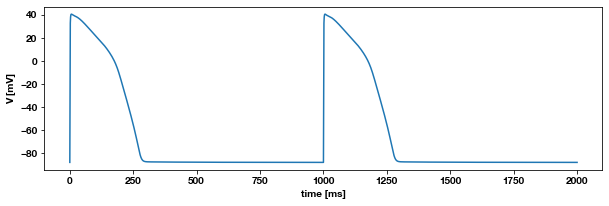

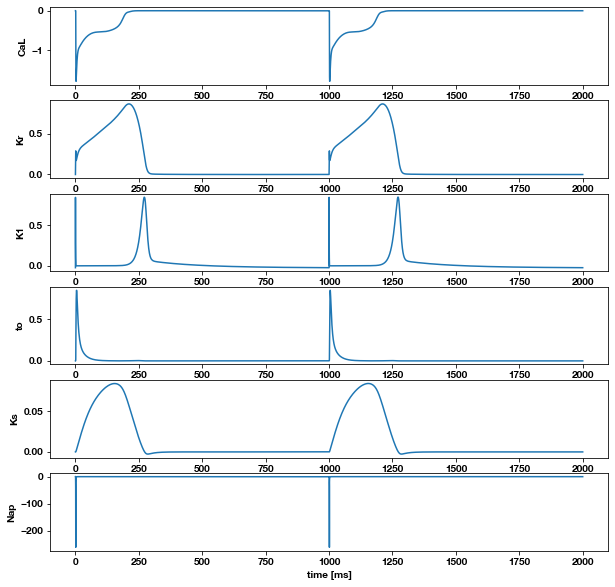

In [3]:
fig = plt.figure()
fig.set_size_inches((10,3))

plt.plot(time_base, V_base)
plt.ylabel('V [mV]')
plt.xlabel('time [ms]')

fig = plt.figure()
fig.set_size_inches((10,10))
for i, o in enumerate(order):
    plt.subplot(len(order), 1, i + 1)
    plt.plot(time_base, d_base[dict_currents[o]])
    plt.ylabel(o)
    
plt.xlabel('time [ms]')

Block the 6 different currents by 90% to understant their contribution to the action potential. This simulates the application of a drug that block specific channels.

Text(0.5, 0, 'time [ms]')

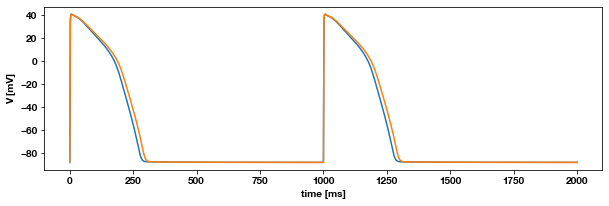

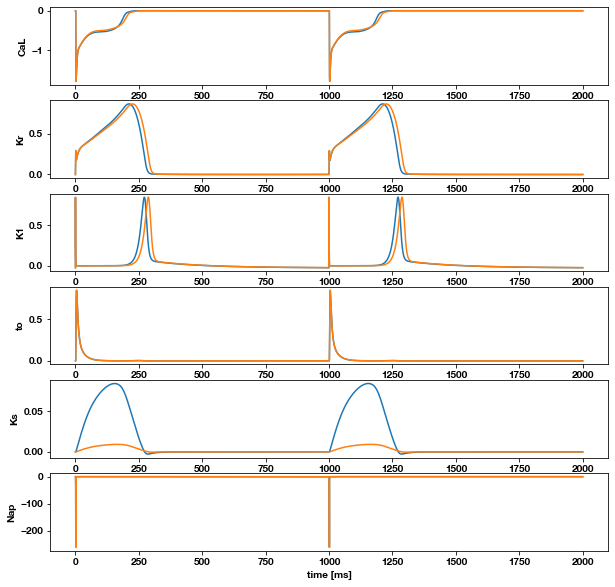

In [10]:
s = myokit.Simulation(m, p)
s.set_constant('cell.mode', 0)

# currents: 'CaL','Kr','K1','to','Ks','Nap'
# change the current in the next line
s.set_constant(dict_blocks['Ks'], 0.1) # 0.1 means 1 - 0.9 = 90% block


s.pre(total_time - 2*CL)
d = s.run(2*CL, log = ['membrane.V','engine.time'] + [dict_currents[o] for o in order])

time = np.array(d['engine.time'])
V = np.array(d['membrane.V'])

fig = plt.figure()
fig.set_size_inches((10,3))

plt.plot(time_base, V_base)
plt.plot(time, V)
plt.ylabel('V [mV]')
plt.xlabel('time [ms]')

fig = plt.figure()
fig.set_size_inches((10,10))
for i, o in enumerate(order):
    plt.subplot(len(order), 1, i + 1)
    plt.plot(time_base, d_base[dict_currents[o]])
    plt.plot(time, d[dict_currents[o]])
    plt.ylabel(o)
    
plt.xlabel('time [ms]')

### Refractory period

Cardiac cells have some protection to sudden changes in rhythm. There is phase during the action potential that another action potential can't be initiated if another stimulus is applied.

Protocol: pace for 30 beats at a cycle lenght of 1000 ms, then apply a stimulus after `S2` miliseconds.

- Reduce the value of `S2` until a second action potential is not created.



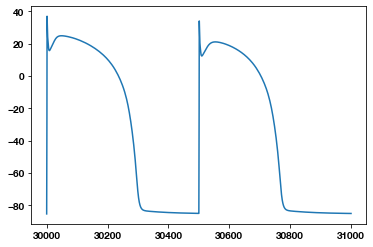

In [12]:
m, p, x = myokit.load('CardiacEP/tentusscher-2006.mmt')

CL = 1000
S2 = 500
cycles = 30
total_time = CL*cycles + 2*S2

p = myokit.Protocol()
p.schedule(1, start = 0, duration = 1.0, period = CL, multiplier = cycles)
p.schedule(1, start = CL*cycles , duration = 1.0, period = S2, multiplier = 2)

s = myokit.Simulation(m, p)
#s.set_constant('cell.mode', 0)

#s.set_constant(dict_blocks['Nap'], 0.01)


#s.pre(total_time - 2*CL)
d_base = s.run(total_time - 2*S2)
d_base = s.run(2*S2, log = ['membrane.V','engine.time'])

time_base = np.array(d_base['engine.time'])
V_base = np.array(d_base['membrane.V'])

plt.plot(time_base,V_base)

## Automaticity

Automaticity refers to the ability of pacemakers cells to excite themselves. The sinoatrial node is responsible for setting the pace in the entire heart. If it fails, the atrioventricular node will start pacing and if it fails, Purkinje cells will start pacing the ventricles. How are they coordinated so they all not pace at the same time?

The next simulation shows the action potential of Purkinje cells paced with a cycle length of 1000 ms, simulating pacing from the sinoatrial node. Modify that cycle length `CL` to a bigger value to simulate the failure of both the sinoatrial node and the atrioventricular node. 

In [29]:
m, p, x = myokit.load('CardiacEP/stewart-2009.mmt')

CL = 1000
cycles = 30
total_time = CL*cycles

p = myokit.Protocol()
p.schedule(1, start = 0, duration = 0.5, period = CL, multiplier = cycles)

s = myokit.Simulation(m, p)

#s.set_constant(dict_blocks['Nap'], 0.01)


s.pre(total_time - 5*CL)
d = s.run(2*CL, log = ['membrane.V','engine.time', 'if.i_f_Na', 'if.i_f_K'])

time = np.array(d['engine.time'])
V = np.array(d['membrane.V'])

Text(0.5, 0, 'time [ms]')

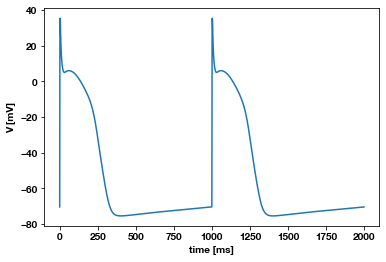

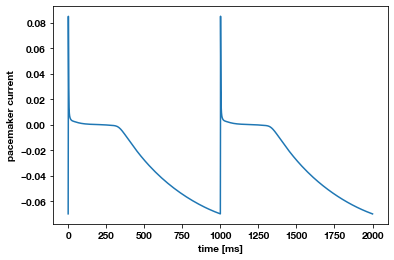

In [30]:
plt.plot(time,V)
plt.ylabel('V [mV]')
plt.xlabel('time [ms]')

plt.figure()
plt.plot(time, np.array(d['if.i_f_Na']) + np.array(d['if.i_f_K']))
plt.ylabel('pacemaker current')
plt.xlabel('time [ms]')



## Early afterdepolarizations

These are depolarizations (activations) that occur in the phase 2 or 3 of the action potential. These are tipically caused by drugs that block $I_{kr}$ or by an enhancement $I_{CaL}$

- Block the `Kr` current by 70% 
- Multiply the `CaL` current by 5
- Block again the `Kr` current by 70% and decrease the `CL` to 600 ms
- Block again the `Kr` current by 70% and 65% with `CL` to 1000 and 2000 ms

Text(0.5, 0, 'time [ms]')

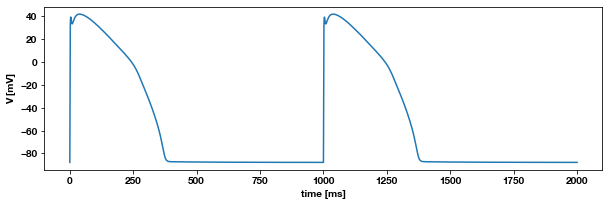

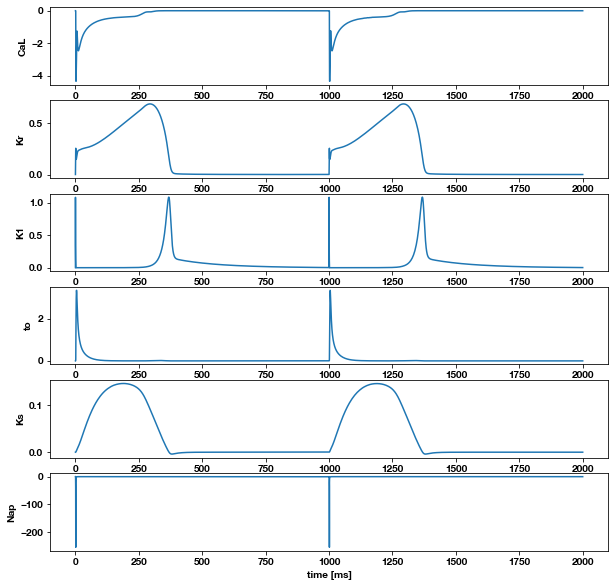

In [4]:
m, p, x = myokit.load('CardiacEP/ohara-2011.mmt')

dict_blocks = {'Nap': 'ina.block',
                    'Kr': 'ikr.block',
                    'Ks': 'iks.block',
                    'K1': 'ik1.block',
                    'CaL': 'ical.block',
                    'to': 'ito.block'
                }

dict_currents = {'Nap': 'ina.INa',
                    'Kr': 'ikr.IKr',
                    'Ks': 'iks.IKs',
                    'K1': 'ik1.IK1',
                    'CaL': 'ical.ICaL',
                    'to': 'ito.Ito'
                }


order = ['CaL','Kr','K1','to','Ks','Nap']

CL = 1000
cycles = 30
total_time = CL*cycles

p = myokit.Protocol()
p.schedule(1, start = 0, duration = 0.5, period = CL, multiplier = cycles)

s = myokit.Simulation(m, p)
s.set_constant('cell.mode', 2) # set cell type to M-cell

s.set_constant(dict_blocks['Kr'], 1.0)


s.pre(total_time - 2*CL)
d_base = s.run(2*CL, log = ['membrane.V','engine.time'] + [dict_currents[o] for o in order])

time_base = np.array(d_base['engine.time'])
V_base = np.array(d_base['membrane.V'])

fig = plt.figure()
fig.set_size_inches((10,3))

plt.plot(time_base, V_base)
plt.ylabel('V [mV]')
plt.xlabel('time [ms]')

fig = plt.figure()
fig.set_size_inches((10,10))
for i, o in enumerate(order):
    plt.subplot(len(order), 1, i + 1)
    plt.plot(time_base, d_base[dict_currents[o]])
    plt.ylabel(o)
    
plt.xlabel('time [ms]')